# Data-driven Identification of linearized dynamics of a Non-linear System (3D Pendulum) & Eigenvalue estimation using Koopman Operator Theory and Prony's method

# Pre-Requisites

## 1. Koopman Operator Theory

- [Refer the the description section](https://github.com/GaloisInc/dlkoopman?tab=readme-ov-file#description)

## 2. Prony's method

- It is a way of fitting exponentials to a time-series data and powers of those corresponds to eigenvalues of the system.

(This method alone is worth a separate approach and this is used since I couldn't find a way to extract eigenvalues of system at *lower dimensions*).

### References

#### For Koopman Operator Theory

1. [Code for the paper "Deep learning for universal linear embeddings of nonlinear dynamics" by Bethany Lusch, J. Nathan Kutz, and Steven L. Brunton](https://github.com/BethanyL/DeepKoopman)

2. [Notes on Koopman Operator Theory
Steven L. Brunton](https://fluids.ac.uk/files/meetings/KoopmanNotes.1575558616.pdf)

#### For Prony's method

1. [A Tutorial on Data-Driven Eigenvalue
Identification: Prony Analysis, Matrix Pencil and
Eigensystem Realization Algorithm](https://web.archive.org/web/20240421173537/https://power.eng.usf.edu/docs/papers/2019/tutorial.pdf)
2. [Exam Question on Fitting Sums of Exponentials to Data](https://sachinashanbhag.blogspot.com/2017/08exam-question-on-fitting-sums-of.html)

# Approach

- First the 3D pendulum system was simulated in MATLAB by using the DAE provided and various collection of state trajectories (a list of ($\psi$, $\theta$), with each of 51 states) were generated & stored in XTrain, XTest, XVal arrays in a zip file (*available in our [GitHub repository]()*).

- The range of initial conditions are (used for simulation) : $\psi \ \epsilon \ [- \pi, \pi]$,   $\theta \ \epsilon \ [- 0.01, 0.01]$
  - To learn the linearized dynamics around this operating equilibrium point.

- Then using the data the Koopman matrix (size: 50x50) was learned through deep learning.
  - Using the [dlkoopman](https://github.com/GaloisInc/dlkoopman) package

- Next using the learned Koopman Matrix a state trajectory was generated.

- Then using Prony's method, the eigenvalues are estimated.

# Setup

## Setup Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/3DP_KOOP_1       #NOTE: Upload the Zip file, with this folder name in you drive before hand

/content/drive/MyDrive/3DP_KOOP_1


In [3]:
import zipfile
import pandas as pd
import os

zip_file_name = "3dp3.zip"
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall()
extracted_files = os.listdir()

In [4]:
import glob
import numpy as np
def load_csv_files(directory):
    data_dict = {}

    # Get list of all CSV files in the directory
    csv_files = glob.glob(os.path.join(directory, '*.csv'))

    for csv_file in csv_files:
        # Extract filename from path
        filename = os.path.basename(csv_file)
        # Load CSV file into numpy array
        data = np.loadtxt(csv_file, delimiter=',')
        # Store numpy array in dictionary with filename as key
        data_dict[filename] = data

    return data_dict

directory = '/content/drive/MyDrive/3DP_KOOP_1'
csv_data = load_csv_files(directory)
# Access data using filenames as keys
for filename, data in csv_data.items():
    print(f'Filename: {filename}, Shape: {data.shape}')


Filename: 3DPendulum1_test_x.csv, Shape: (25500, 4)
Filename: 3DPendulum1_train1_x.csv, Shape: (178500, 4)
Filename: 3DPendulum1_train2_x.csv, Shape: (178500, 4)
Filename: 3DPendulum1_train3_x.csv, Shape: (178500, 4)
Filename: 3DPendulum1_val_x.csv, Shape: (51000, 4)


In [5]:
Xtest_arr = []
for filename, data in csv_data.items():
    if filename == '3DPendulum1_test_x.csv' :
      Xtest = data.reshape(500,51,4)[:,:,:2]
    if filename == '3DPendulum1_val_x.csv' :
      Xval = data.reshape(1000,51,4)[:,:,:2]

    else :
      Xtest_arr.append(data)

In [6]:
for i in range(len(Xtest_arr)) :
  print(Xtest_arr[i].shape)

(25500, 4)
(178500, 4)
(178500, 4)
(178500, 4)


In [7]:
Xtrain = np.concatenate((Xtest_arr[1],Xtest_arr[2],Xtest_arr[3]), axis=1).reshape(10500,51,4)[:,:,:2]

## Install and Setup `dlkoopman` library

In [8]:
!pip install dlkoopman

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [50]:
from dlkoopman.traj_pred import *
from dlkoopman import utils
import numpy as np
import scipy
import cmath
import math
import time

In [10]:
dh = TrajPredDataHandler(      # For Loading data
    Xtr=Xtrain,
    Xva=Xval,
    Xte=Xtest
)


In [11]:
utils.set_seed(10)

In [12]:
tp = TrajPred(
    dh = dh,
    encoded_size = 50 #50
)

Log file = /content/drive/MyDrive/3DP_KOOP_1/log_cTTVMiy7bUa5wpDqMNRaMy.log


# Prony's method

- Refer pages 2, 3 from `Prony's Method Reference 1` for the math & approach followed in the below code

In [45]:
# Prony's method
def prony(XData,tdiff):
  N,num = XData.shape
  N = N-1
  n = num
  eig = np.zeros([n,1])
  hank_arr_inv = np.zeros([num,n,N+1-n])
  y_arr = np.zeros([num,N+1-n,1])
  # a_coeff = np.array([-1,0,0]).reshape(3,1)
  a_coeff = np.array([-1] + [0]*(n)).reshape(n+1,1)
  for i in range(num):
    hank_arr_inv[i,:,:] = scipy.linalg.pinv(scipy.linalg.hankel(XData[n-1:N,i],XData[N-n:N,i][::-1]))
    y_arr[i,:,:] = XData[n:N+1,i].reshape(N+1-n,1)
  a_coeff_tmp = np.hstack((hank_arr_inv[0,:,:],hank_arr_inv[1,:,:]))@np.vstack((y_arr[0,:,:],y_arr[1,:,:]))
  a_coeff[1:] =  a_coeff_tmp
  roots = np.roots(a_coeff.reshape(n+1))
  for i in range(len(roots)):
    eig[i] = (cmath.log(roots[i])/tdiff).imag
    print(cmath.log(roots[i])/tdiff)
  return eig

# Linearize the Dynamics and estimate Eigenvalues

## Training the neural networks  and learning the Koopman matrix

In [13]:
tp.train_net()
tp.test_net()

100%|██████████| 10/10 [01:52<00:00, 11.25s/it]


Saving figure /content/drive/MyDrive/3DP_KOOP_1/plot_cTTVMiy7bUa5wpDqMNRaMy_pred_loss.png
Saving figure /content/drive/MyDrive/3DP_KOOP_1/plot_cTTVMiy7bUa5wpDqMNRaMy_total_loss.png


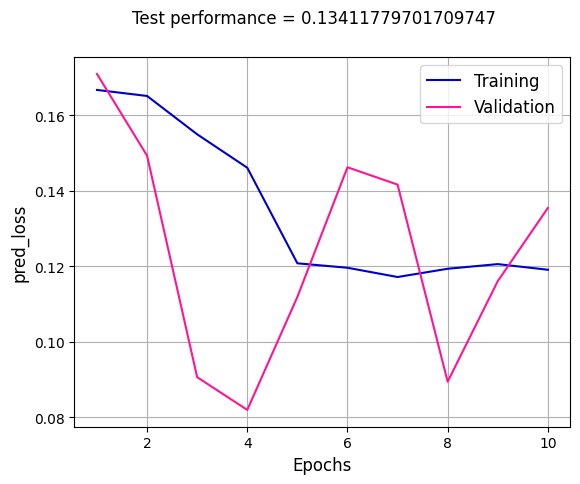

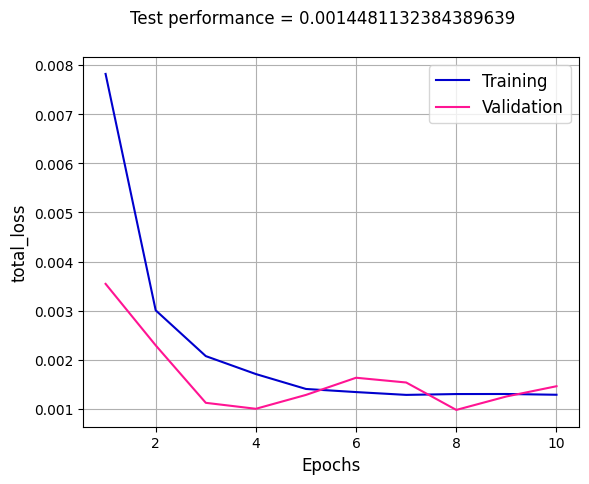

In [14]:
utils.plot_stats(tp, ['pred_loss', 'total_loss'])


## Generate a trajectory and estimate the eigenvalues

In [79]:
st = time.time()
T = tp.predict_new([[0,1.366]]).reshape(51,2) #Initial condition i.e initial state is from Xtest, #print(Xtest[0,0,:])
#print(T[0,:])
eig_arr = prony(T.numpy(),1)      # with Koopman method
ed = time.time()
time_taken = ed-st

0j
3.141592653589793j


# Benchmarking

Currently there's a spurious eigenvalue(0) being estimated. **As mentioned in the [Problem Statement Document](https://www.iftomm-multibody.org/media/problems/3d%20simple%20pendulum/3d%20simple%20pendulum_vr6JJJS.pdf)**

> Spurious eigenvalues may also be obtained; these must be discriminated from the real system spectrum.

It is ok to get those and this can be attributed to the use of *default hyperparameters*. By **tuning the hyperparameters** (`Hyperparameter Optimization`) we can obtain more good results and thereby avoiding such estimation.

In [78]:
# Accuracy
exact_eigs = np.array([-math.sqrt(9.81),math.sqrt(9.81)])
accuracy_1 = np.linalg.norm(eig_arr-exact_eigs)
accuracy_2 = np.linalg.norm(eig_arr[1:]-exact_eigs[1:]) # neglecting the spurious eigenvalue
print("Accuracy with the spurious eigenvalue:",accuracy_1)
print("Accuracy without the spurious eigenvalue:",accuracy_2)

# CPU time

print("CPU time for 10,000 linearizations",(((10000*time_taken)+112)/60),"minutes")

# 112s for learning Koopman matrix (Since it is an Global linearization, one time is enough)
# time_taken corresponds to time taken for trajectory generation & eigenvalue estimation

Accuracy with the spurious eigenvalue: 7.679792236914923
Accuracy without the spurious eigenvalue: 0.009500700916627913
CPU time for 10,000 linearizations 6.962307484944661 minutes


# Future Prospects

One of the benefits of using Koopman Operator Theory is that,
  - Based on the availability of large data, we can obtain the **Global Linearization** of the system, thereby we need not to linearize the system about an Operating point. (Here though with less data its not Globally Linearized but it can be)

### Future works

- Doing `Hyperparameter optimization` of Neural Networks will lead to improved results.

- Use of analytical techniques such as DMD (Dynamic Mode Decomposition) instead of Deep Learning for learning Koopman Matrix can improve the linearization speeds.

- Also finding ways to estimate **eigenvalues of the system in the lower dimensions** from higher dimensional Koopman matrix or using other related properties can eliminate the need for the second method (Prony's method).